In [1]:
# imports
from PIL import Image
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image

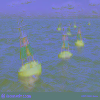

(100, 100, 3)


In [3]:
# obtain the image and prepare for testing
test = cv2.imread('/content/drive/MyDrive/Buoys/buoys10.jpg', 1)
# test = cv2.medianBlur(test, 51)
test = cv2.resize(test, (100, 100))
test = cv2.cvtColor(test, cv2.COLOR_BGR2LAB)
cv2_imshow(test)
im = test
print(im.shape)

In [4]:
# obtain pixel arrays and superpixel objects, complete kmeans
pix2d = np.array(im)
pix = pix2d.reshape(-1, 3)
pix2d_2 = np.empty((pix2d.shape[0], pix2d.shape[1]), tuple)
superpixels = np.empty((pix2d.shape[0] * pix2d.shape[1], 3))
model = KMeans(n_clusters = 8).fit(pix)
centers = model.cluster_centers_.astype(int)
labels = model.predict(pix)
labels2d = labels.reshape(pix2d.shape[0], pix2d.shape[1])

index = 0
for x in range(pix2d.shape[0]):
    for y in range(pix2d.shape[1]):
        pix2d_2[x, y] = tuple(centers[labels2d[x, y]])
        superpixels[index] = np.array([x, y, labels2d[x, y]])
        index += 1

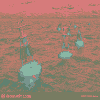

In [5]:
# display new kmeans image
im_2 = Image.new('RGB', (100, 100))
im_2.putdata(pix2d_2.reshape(-1))
# im_2.save("{}.png".format('buoy_kmeans'), "PNG")
display(im_2)

# Plot

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [7]:
rand_mask = np.full(pix.shape[0], False)
rand_mask[:1000] = True
np.random.shuffle(rand_mask)
sample = pix[rand_mask]
sample

array([[223, 121, 123],
       [221, 124, 123],
       [221, 124, 129],
       ...,
       [119, 123,  90],
       [119, 123,  90],
       [121, 122,  91]], dtype=uint8)

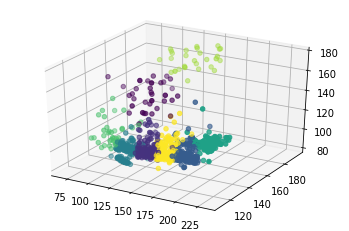

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(sample[:,0], sample[:,1], sample[:,2], c=labels[rand_mask])

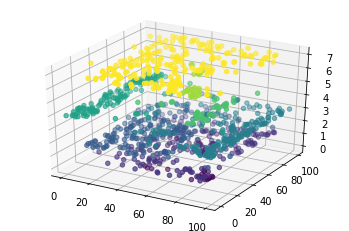

In [9]:
super_sample = superpixels[rand_mask]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(super_sample[:,0], super_sample[:,1], super_sample[:,2], c=labels[rand_mask])

# See

In [10]:
pixdict = {tuple(c): [] for c in centers} #

In [11]:
for x in range(pix2d.shape[0]): 
  for y in range(pix2d.shape[1]):
    pixdict[pix2d_2[x, y]].append([x, y])
for c in pixdict:
  pixdict[c] = np.array(pixdict[c])

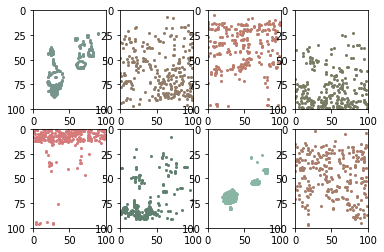

In [12]:
row, col = 2, 4

fig, axs = plt.subplots(row, col) 

for i, c in enumerate(pixdict):
  rand_mask = np.full(pixdict[c].shape[0], False)
  rand_mask[:250] = True
  np.random.shuffle(rand_mask)
  sample = pixdict[c][rand_mask]
  axs[i//col, i%col].set_ylim(pix2d.shape[0], 0)
  axs[i//col, i%col].set_xlim(0, pix2d.shape[1])
  axs[i//col, i%col].scatter(sample[:, 1], sample[:,0], color=np.array(c)/255, s=4)

#Experiment

In [13]:
from google.colab.patches import cv2_imshow

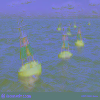

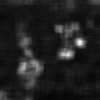

In [14]:
# https://www.pyimagesearch.com/2018/07/16/opencv-saliency-detection/
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(im)
saliencyMap = (saliencyMap * 255).astype("uint8")
cv2_imshow(im)
cv2_imshow(saliencyMap)

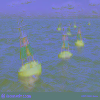

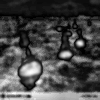

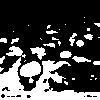

In [15]:
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(im)
saliencyMap = (saliencyMap * 255).astype("uint8")
threshMap = cv2.threshold(saliencyMap.astype("uint8"), 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

cv2_imshow(im)
cv2_imshow(saliencyMap)
cv2_imshow(threshMap)

# Cluster

In [16]:
# obtain standard deviations
stds = set()
for c in pixdict:
  points = pixdict[c]
  x_avg = np.average(points[:,0])
  y_avg = np.average(points[:,1])
  distances = np.empty((len(points)))
  for i in range(len(points)):
    distances[i] = ((points[i,0]-x_avg)**2+(points[i,1]-y_avg)**2)**0.5
  std = np.std(distances)
  stds.add((std, c))

# obtain all objects with std under tolerance
print(sorted(stds))
best = [obj for obj in sorted(stds) if obj[0] < 11]
if best == []:
  best = sorted(stds)[0:3]
best_colors = [b[1] for b in best]


[(9.40950080939106, (119, 148, 141)), (10.915613203719891, (137, 182, 164)), (13.441907076706714, (96, 129, 112)), (13.968318437731693, (145, 124, 105)), (14.011052346795967, (167, 124, 106)), (14.48440898271202, (120, 124, 98)), (14.655800623471933, (187, 124, 108)), (17.05655843152521, (214, 123, 123))]


In [17]:
# recolor image with detected objects
pix2d_algo = np.copy(pix2d_2)

obj_colors = [(255, 95, 31), (255, 240, 31), (125, 249, 255), (0, 255, 255), (255, 0, 255), (255, 255, 0)]

for i in range(len(best)):
  for pair in pixdict[best_colors[i]]:
    pix2d_algo[pair[0], pair[1]] = obj_colors[i]

'''for color in pixdict:
  if color not in best_colors:
    for pair in pixdict[color]:
      pix2d_algo[pair[0], pair[1]] = '''

pix2d_algo.shape

(100, 100)

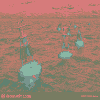

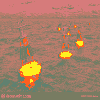

In [18]:
# display detected objects
im_algo = Image.new('RGB', (100, 100))
im_algo.putdata(pix2d_algo.reshape(-1))
display(im_2)
display(im_algo)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


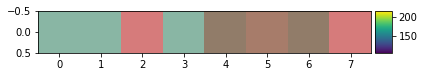

In [19]:
# show color palette of the image (changed)

palette = np.array([x for x in pixdict.keys()])
from skimage import io

indeces = np.random.randint(0, len(palette), size=(1, 8))
io.imshow(palette[indeces])